In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as ipw

Define functions for plotting with plotly + ipywidgets

In [31]:
def group_then_plot_by_group(
    df_base: pd.DataFrame,
    groupby_col: str,
    index_col: str,
    values_col: str,
    labels: dict = {},
    title: str = '',
    layout: dict = {},
    show_fig: bool = True
) -> None:
    index_vals = sorted(list(set(df_base[index_col])))
    groups = df_base.groupby(groupby_col)
    grouped_df = pd.DataFrame({index_col: index_vals})
    
    for name, df in groups:
        col_vals = []
        df = df.set_index(index_col)
        for idx in index_vals:
            if idx in df.index:
                col_vals.append(df.loc[idx][values_col])
            else:
                col_vals.append(np.nan)
        grouped_df[name] = col_vals
        
    fig = px.line(
        grouped_df,
        x=index_col,
        y=[col for col in grouped_df.columns if col != index_col],
        labels=labels,
        title=title
    )
    
    if len(layout) > 0:
        fig.update_layout(**layout)
        
    fig.update_yaxes(range = [0,100])
     
    fig = go.FigureWidget(fig)
    
    if show_fig:
        fig.show(renderer="png")
        
    return fig


def make_subplots_by_region(
    df_with_regions: pd.DataFrame, 
    region_col: str, 
    groupby_col, 
    index_col,
    values_col,
    labels: dict = {},
    title: str = '',
    layout: dict = {}
):
    grouped_regional_dfs = df_with_regions.groupby(region_col)
    num_regions = len(grouped_regional_dfs)
    rows = []
    
    for row_col_index, (region, region_specific_df) in enumerate(grouped_regional_dfs):
        if row_col_index == 0:
            row = []
        elif row_col_index % 1 == 0:
            rows.append(ipw.HBox(row))
            row = []
            
        fig = group_then_plot_by_group(
            df_base=region_specific_df,
            groupby_col=groupby_col,
            index_col=index_col,
            values_col=values_col,
            labels=labels,
            title=region + ': ' + title,
            layout=layout,
            show_fig=True
        )
        row.append(fig)
        
    rows.append(ipw.HBox(row))
    subplots = ipw.VBox(rows)
    
    return subplots

## Share of individuals using the Internet

In [32]:
df_internet = pd.read_csv('share-of-individuals-using-the-internet.csv')

In [33]:
print('Number of countries: ' + str(len(list(set(df_internet['Entity'])))))

Number of countries: 258


There are many countries, which overcrowds the line plot, so I decided to split by region. I used the (tab-separated) table mapping countries to regions from [the International Telecommunications Union](https://meta.wikimedia.org/wiki/List_of_countries_by_regional_classification). I loaded them into a CSV (rather, TSV) file, and merged with the Share Of Individuals Using The Internet CSV file.

In [34]:
df_region = pd.read_csv('country_regions.csv', sep='\t')

In [35]:
df = pd.merge(df_internet, df_region, how='left', left_on='Entity', right_on='Country')
df['Region'] = df['Region'].fillna('Misc.')
df['Hemisphere'] = df['Hemisphere'].fillna('Misc.')

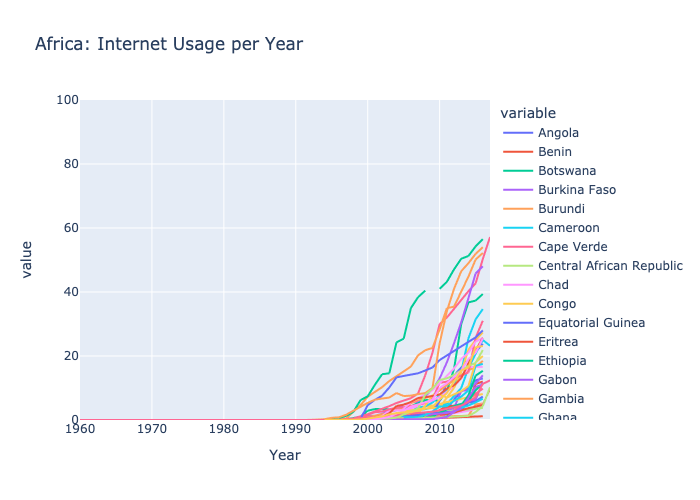

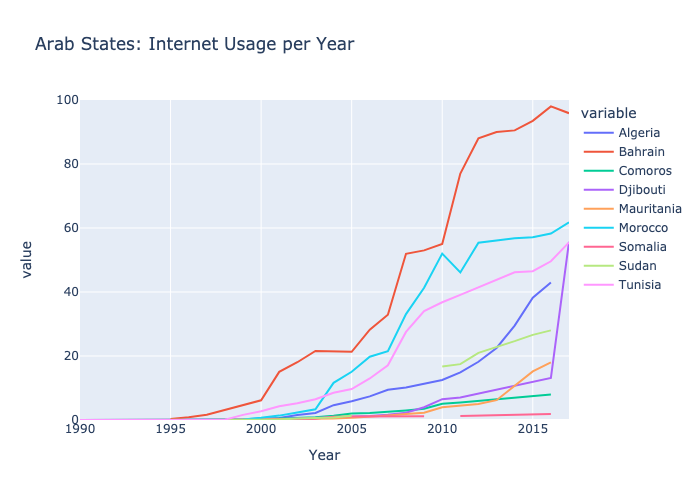

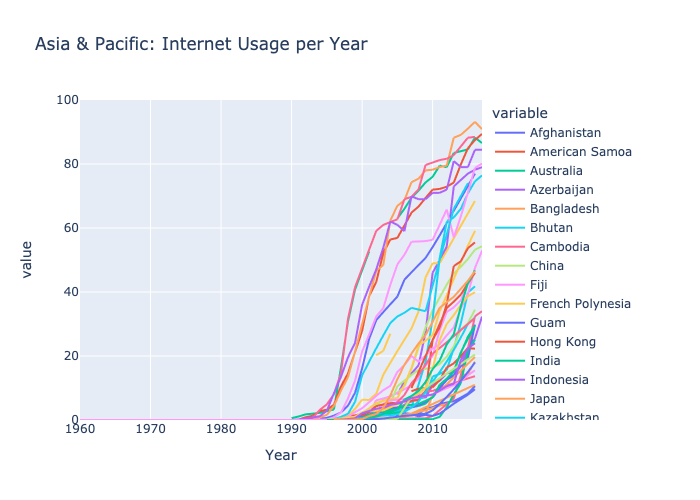

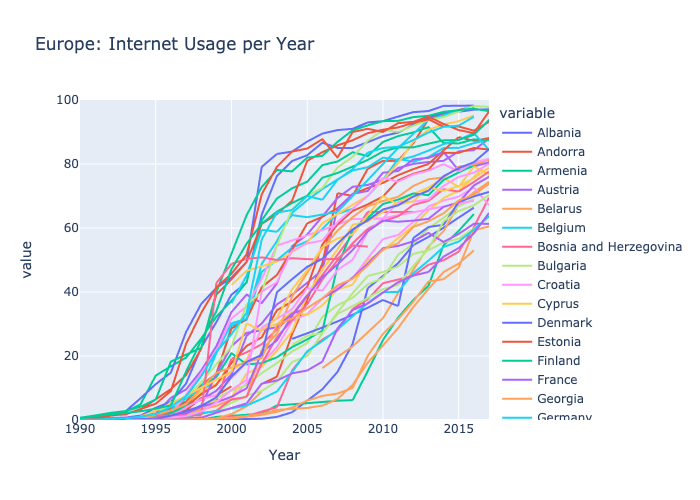

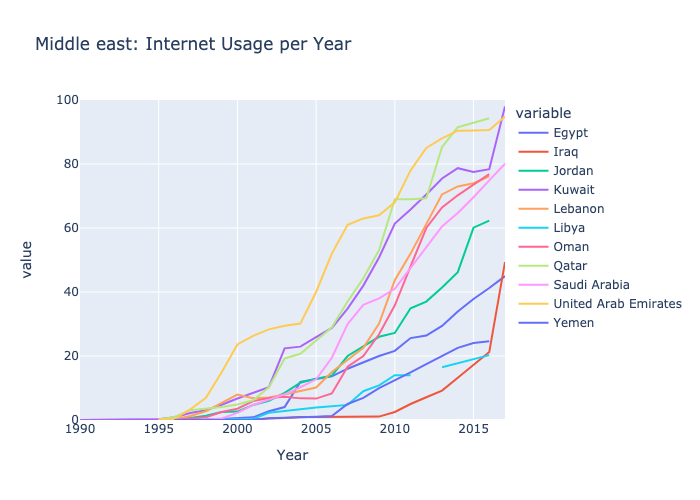

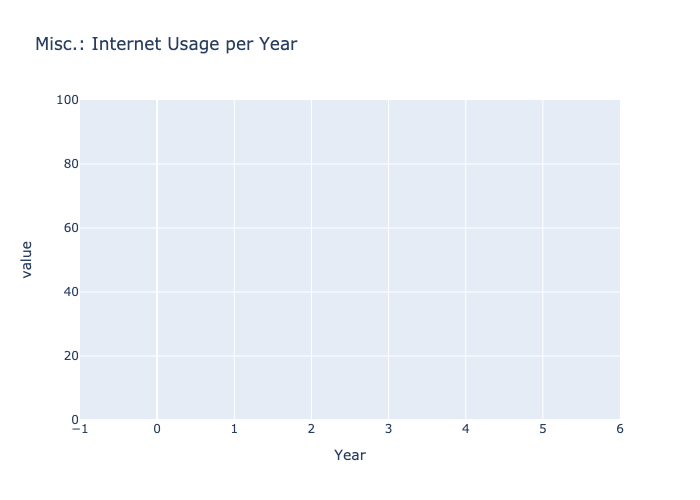

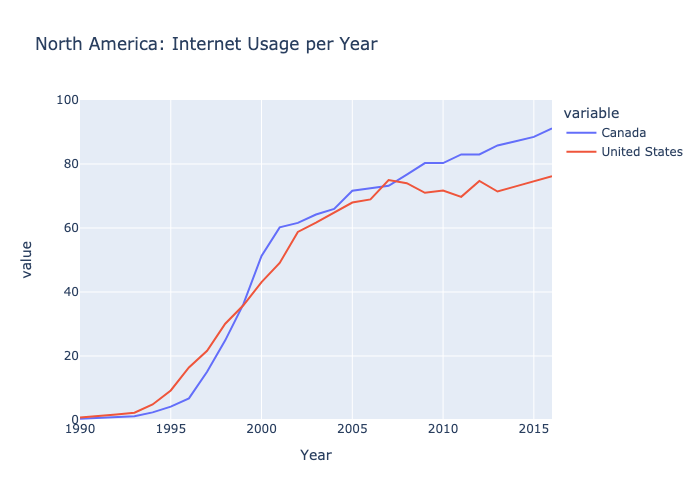

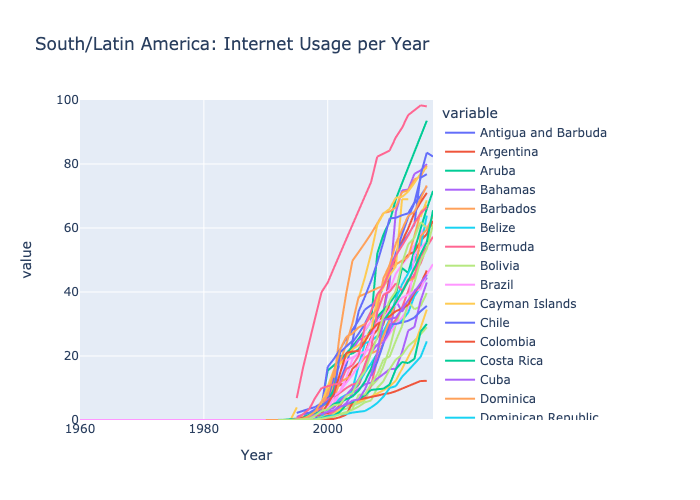

    'data': [{'hovertemplate': 'variable=Angola<br>Year=%{x}<br>v…

In [36]:
fig = make_subplots_by_region(
    df_with_regions=df,
    region_col='Region',
    groupby_col='Country',
    index_col='Year',
    values_col='Individuals using the Internet (% of population)',
    labels={},
    title='Internet Usage per Year',
    layout={}
)

fig

## Cell Phone Usage

In [37]:
df_phone = pd.read_csv('cell_phones_per_100_people.csv')

In [18]:
import math

def typesafe_log(element, base=10):
    try:
        return math.log(float(str(element)), base)
    except:
        return element

In [38]:
# df_transformed = df_phone.applymap(lambda x: typesafe_log(x, 10))
df_transformed = df_phone

In [39]:
df = pd.merge(df_transformed, df_region, how='left', left_on='country', right_on='Country')
df['Region'] = df['Region'].fillna('Misc.')
df['Hemisphere'] = df['Hemisphere'].fillna('Misc.')

In [40]:
transposed = df_transformed.T
cols = transposed.iloc[0]
transposed = transposed[1:]
transposed.columns = cols
transposed.index.names = ['Year']

In [41]:
region_to_country_mapping = {
    r: [] for r in list(set(df_region['Region']))
}

for r, c in zip(df_region['Region'], df_region['Country']):
    region_to_country_mapping[r].append(c)

    
dfs_by_region = {
    r: transposed[[
        x 
        for x in region_to_country_mapping[r] 
        if x in transposed.columns]
    ]
    for r in region_to_country_mapping.keys()
}


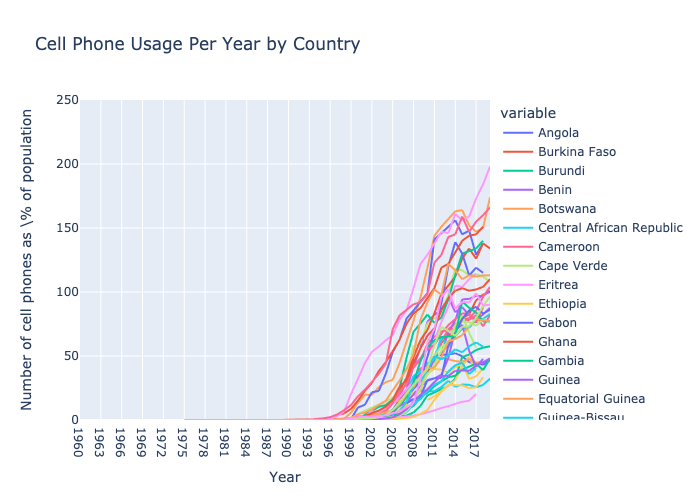

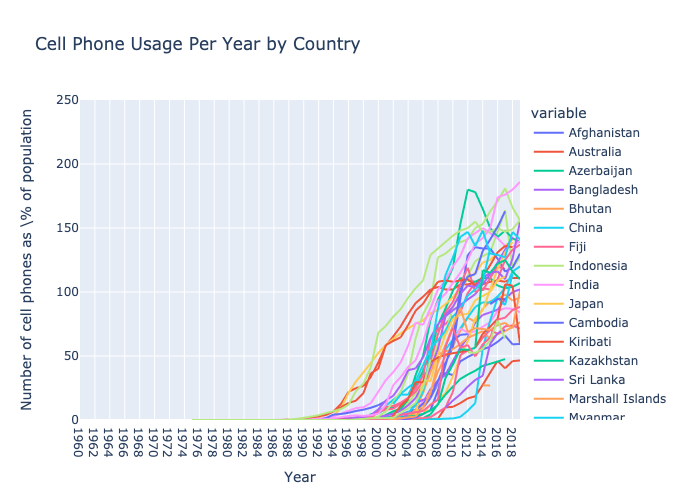

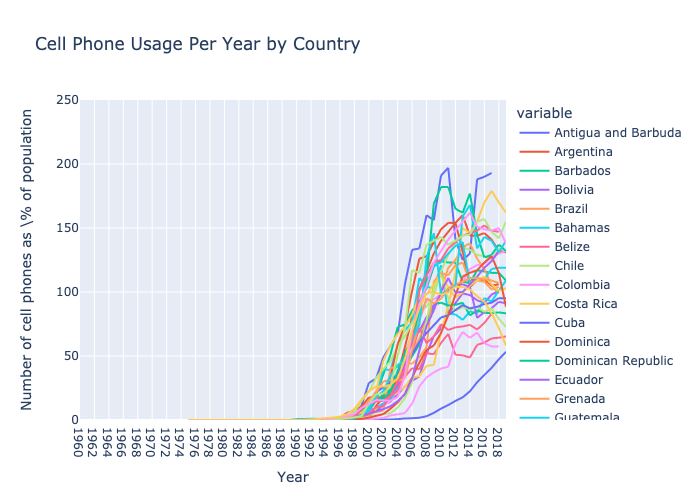

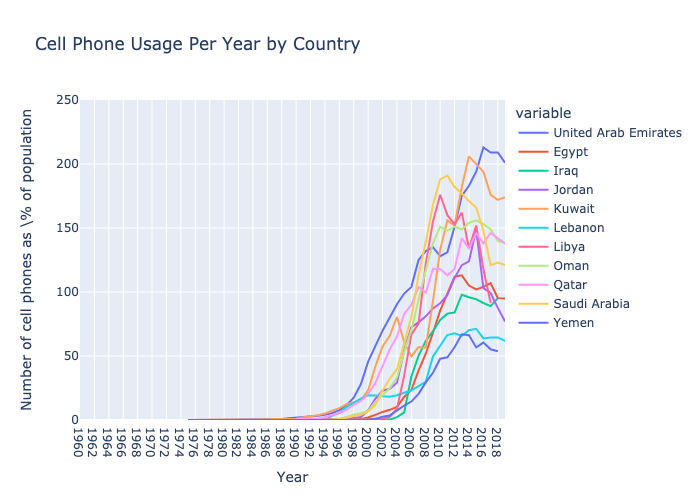

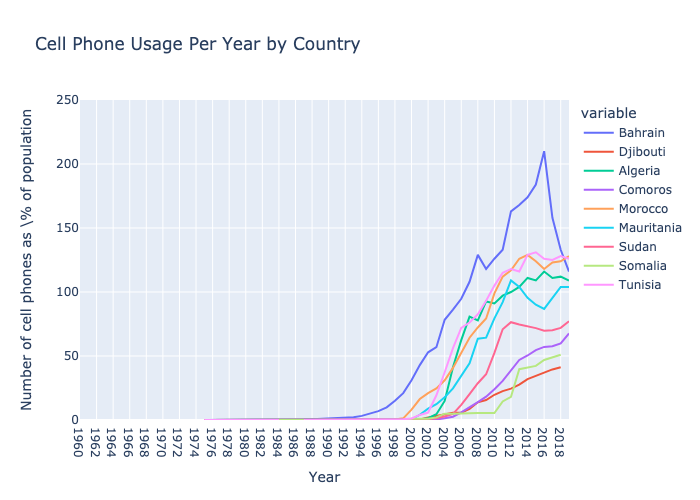

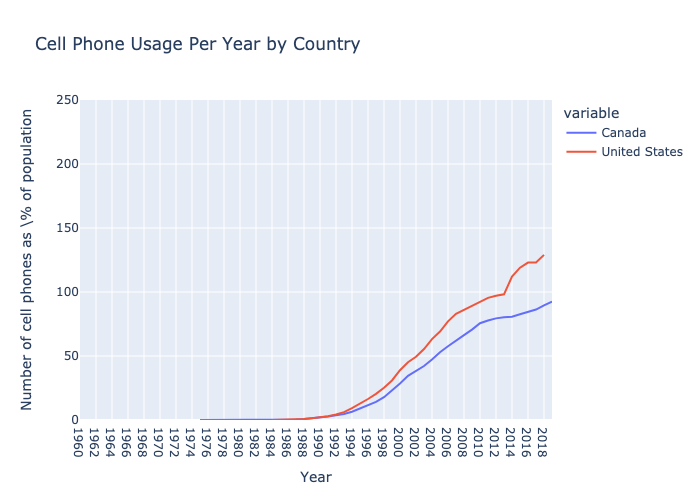

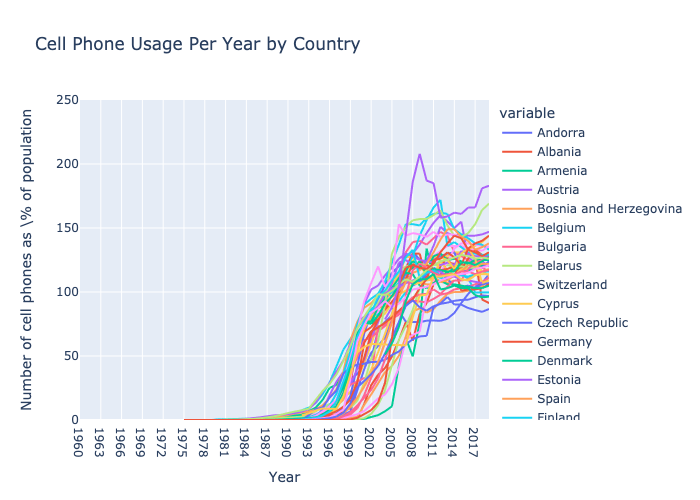

    'data': [{'hovertemplate': 'variable=Angola<br>Year=%{x}<br>v…

In [42]:
rows = []

for row_col_index, (region, regional_df) in enumerate(dfs_by_region.items()):
    if row_col_index == 0:
        row = []
    elif row_col_index % 1 == 0:
        rows.append(ipw.HBox(row))
        row = []

    fig = px.line(
        regional_df,
        x=df.index.name,
        y=[col for col in regional_df.columns if col != df.index.name],
        title='Cell Phone Usage Per Year by Country'
    )
    
    fig.update_layout(
        yaxis_title='Number of cell phones as \% of population'
    )
        
    fig.update_yaxes(range = [0, 250])
    
    fig.show(renderer='png')
     
    fig = go.FigureWidget(fig)
    
    row.append(fig)
        
rows.append(ipw.HBox(row))
subplots = ipw.VBox(rows)

subplots
    

## Visualize hierarchical categorical data

I will visualize the latest year of cell phone usage using a sunburst plot with the path `Region` $\rightarrow$ `Hemisphere` $\rightarrow$ `Country`

In [24]:

df = df.fillna(method='ffill', axis=1)
df_latest = df[['2019', 'Region', 'Hemisphere', 'Country']]
df_latest = df_latest.rename(columns={'2019': 'Percent Phone Usage in 2019'})
df_latest

,Percent Phone Usage in 2019,Region,Hemisphere,Country
0,59.4,Asia & Pacific,Global South,Afghanistan
1,91.3,Europe,Global North,Albania
2,109.0,Arab States,Global South,Algeria
3,114.0,Europe,Global North,Andorra
4,46.6,Africa,Global South,Angola
...,...,...,...,...
189,58.1,South/Latin America,Global South,Venezuela
190,141.0,Asia & Pacific,Global South,Vietnam
191,53.7,Middle east,Global South,Yemen
192,96.4,Africa,Global South,Zambia


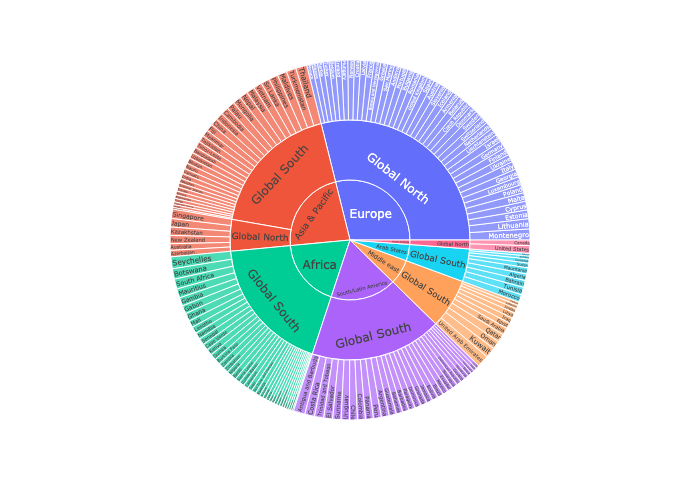

In [43]:
df_filtered = df_latest[df_latest.Region != 'Misc.']
fig = px.sunburst(df_filtered, path=['Region', 'Hemisphere', 'Country'], values='Percent Phone Usage in 2019')
fig.show(renderer='png')

In [44]:
# interactive
fig